
Номер в списке - 25 => вариант 5
Построить нечеткую базу знаний (использовать не менее 3 лингвистических переменных) 
для задачи регулирования теплоснабжения (соотношение среднесуточной температуры, ветра, размера здания и т.д.),
проверить ее на полноту и произвести нечеткий вывод для конкретных значений (выбрать случайным образом)

Входные переменные для регулирования теплоснабжения:
1. Лингвистическая переменная "Среднесуточная температура" (низкая, средняя, высокая) 
2. Лингвистическая переменная "Скорость ветра" (слабая, средняя, сильная) 
3. Лингвистическая переменная "Размер здания" (маленький, средний, большой)

In [59]:

import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# входные переменные для задачи - регулирование теплоснабжения (среднесуточная температура, скорость ветра, размер здания)
average_daily_temperature = ctrl.Antecedent(np.arange(0, 40, 1), 'average_daily_temperature') # в градусах
wind_speed = ctrl.Antecedent(np.arange(0, 12, 1), 'wind_speed') # по шкале Бофорта
building_size = ctrl.Antecedent(np.arange(5, 100, 1), 'building_size') # в метрах
# выходная переменная - уровень теплоснабжения
heat_supply_level = ctrl.Consequent(np.arange(20, 250, 1), 'heat_supply_level') 

# используем стандартную функцию принадлежности (треугольник)
heat_supply_level.automf(names=['low', 'medium', 'high'])

average_daily_temperature['low'] = fuzz.trapmf(average_daily_temperature.universe, [0, 5, 10, 10])
average_daily_temperature['medium'] = fuzz.trapmf(average_daily_temperature.universe, [10, 15, 20, 25])
average_daily_temperature['high'] = fuzz.trapmf(average_daily_temperature.universe, [20, 30, 40, 40])

wind_speed['low'] = fuzz.trapmf(wind_speed.universe, [0, 2, 4, 6])
wind_speed['medium'] = fuzz.trapmf(wind_speed.universe, [4, 6, 7, 8])
wind_speed['high'] = fuzz.trapmf(wind_speed.universe, [7, 10, 12, 12])

building_size['small'] = fuzz.trapmf(building_size.universe, [5, 10, 20, 30])
building_size['medium'] = fuzz.trapmf(building_size.universe, [20, 30, 40, 50])
building_size['large'] = fuzz.trapmf(building_size.universe, [40, 70, 100, 100])

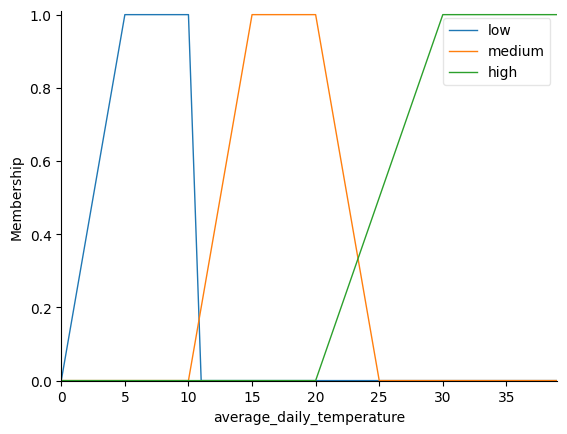

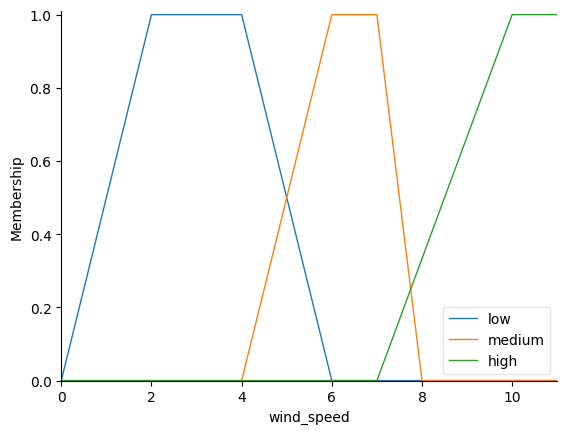

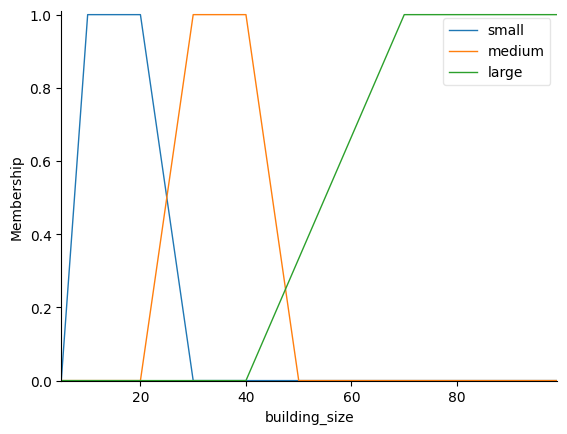

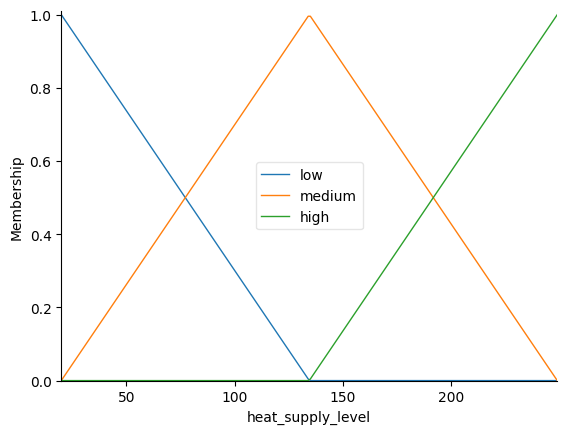

In [60]:
#построение графиков
average_daily_temperature.view()
wind_speed.view()
building_size.view()
heat_supply_level.view()

Введем обозначения
Среднесуточная температура - T
Скорость ветра - S
Размер здания - B

Далее необходимо сформулировать базу правил
1) Если (T низкая) И (S низкая) И ((B маленький) ИЛИ (B средний) ИЛИ (B большой)), то уровень теплоснабжения низкий.
2) Если (T низкая) И (S средняя) И (B маленький), то уровень теплоснабжения низкий.
3) Если (T низкая) И (S средняя) И ((B средний) ИЛИ (B большой)), то уровень теплоснабжения средний.
4) Если (T низкая) И (S высокая) И (B маленький), то уровень теплоснабжения средний.
5) Если (T низкая) И (S высокая) И ((B средний) ИЛИ (B большой)), то уровень теплоснабжения высокий.
6) Если (T средняя) И (S низкая) И ((B маленький) ИЛИ (B средний)), то уровень теплоснабжения низкий.
7) Если (T средняя) И (S средняя) И (B средний), то уровень теплоснабжения средний.
8) Если (T средняя) И ((S средняя) ИЛИ (S высокая)) И (B высокий), то уровень теплоснабжения высокий.
9) Если (T высокая) И (S низкая) И (B низкий), то уровень теплоснабжения низкий.
10) Если (T высокая) И (S средняя) И (B средний), то уровень теплоснабжения средний.
11) Если (T высокая) И ((S средняя) ИЛИ (S высокая)) И (B высокий), то уровень теплоснабжения высокий.

In [61]:
rule1 = ctrl.Rule(average_daily_temperature['low'] & wind_speed['low'] & (building_size['small'] | building_size['medium'] | building_size['large']), heat_supply_level['low'])
rule2 = ctrl.Rule(average_daily_temperature['low'] & wind_speed['medium'] & building_size['small'], heat_supply_level['low'])
rule3 = ctrl.Rule(average_daily_temperature['low'] & wind_speed['medium'] & (building_size['medium'] | building_size['large']), heat_supply_level['medium'])
rule4 = ctrl.Rule(average_daily_temperature['low'] & wind_speed['high'] & building_size['small'], heat_supply_level['medium'])
rule5 = ctrl.Rule(average_daily_temperature['low'] & wind_speed['high'] & (building_size['medium'] | building_size['large']), heat_supply_level['high'])
rule6 = ctrl.Rule(average_daily_temperature['medium'] & wind_speed['low'] & (building_size['small'] | building_size['medium']), heat_supply_level['low'])
rule7 = ctrl.Rule(average_daily_temperature['medium'] & wind_speed['medium'] & building_size['medium'], heat_supply_level['medium'])
rule8 = ctrl.Rule(average_daily_temperature['medium'] & ((wind_speed['medium'] | wind_speed['high']) & building_size['large']), heat_supply_level['high'])
rule9 = ctrl.Rule(average_daily_temperature['high'] & wind_speed['low'] & building_size['small'], heat_supply_level['low'])
rule10 = ctrl.Rule(average_daily_temperature['high'] & wind_speed['medium'] & building_size['medium'], heat_supply_level['medium'])
rule11 = ctrl.Rule(average_daily_temperature['high'] & ((wind_speed['medium'] | wind_speed['high']) & building_size['large']), heat_supply_level['high'])

heat_ctrl = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5, rule6, rule7, rule8, rule9, rule10, rule11])
heat_simulator = ctrl.ControlSystemSimulation(heat_ctrl)

# входные данные
heat_simulator.input['average_daily_temperature'] = 30
heat_simulator.input['wind_speed'] = 9
heat_simulator.input['building_size'] = 90

# результат
heat_simulator.compute()
print(heat_simulator.output['heat_supply_level'])


207.6512084882993


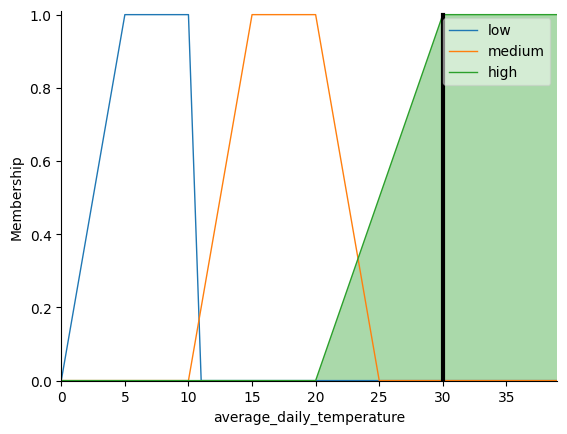

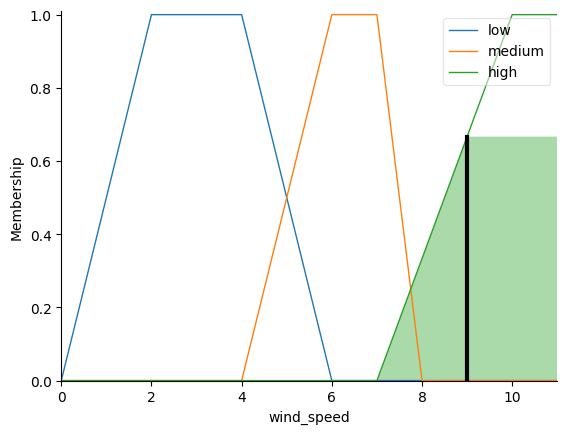

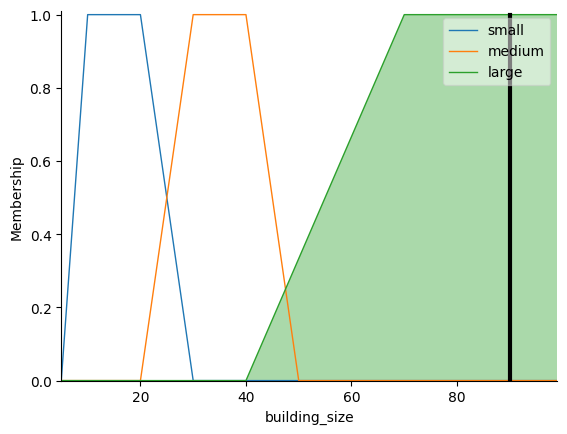

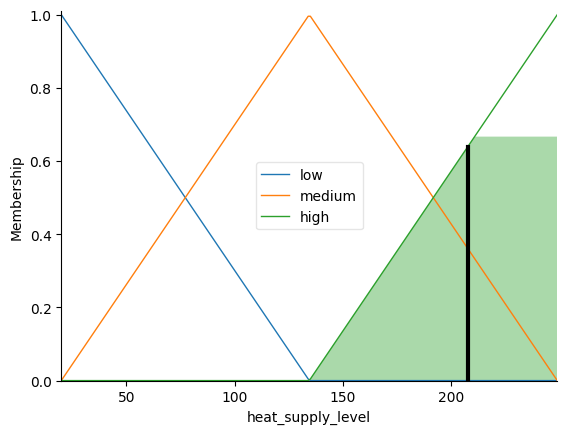

In [62]:
average_daily_temperature.view(sim=heat_simulator)
wind_speed.view(sim=heat_simulator)
building_size.view(sim=heat_simulator)
heat_supply_level.view(sim=heat_simulator)